In [1]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [2]:
from dataset_generator import DatasetGenerator

DatasetGenerator().generate_text_classification_dataset()

Generating text classification dataset...
File already exists, skipping generation.


In [3]:
from datasets import load_dataset, DatasetDict

dataset = load_dataset('csv', data_files='data/dataset_text_classification.csv', delimiter=';')

In [4]:
labels = [label for label in dataset['train'].features.keys() if label not in ['text']]
id2label = {i:label for i, label in enumerate(labels)}
label2id = {v:k for k,v in id2label.items()}

print(labels)

['CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN']


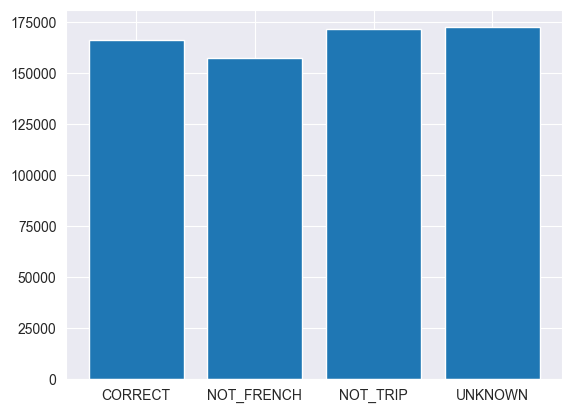

In [5]:
import matplotlib.pyplot as plt

plt.bar(labels, [sum(dataset["train"][label]) for label in labels])
plt.show()

In [6]:
# Shuffle train dataset, and pick 50% of it
train_data = dataset['train']
train_data = train_data.shuffle(seed=42)
train_data = train_data.train_test_split(test_size=0.5)['train']

# Split test dataset into 10% validation and 10% test
train_test_valid = train_data.train_test_split(test_size=0.2)
test_valid = train_test_valid['test'].train_test_split(test_size=0.5)

dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN'],
        num_rows: 199264
    })
    test: Dataset({
        features: ['text', 'CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN'],
        num_rows: 24908
    })
    valid: Dataset({
        features: ['text', 'CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN'],
        num_rows: 24908
    })
})

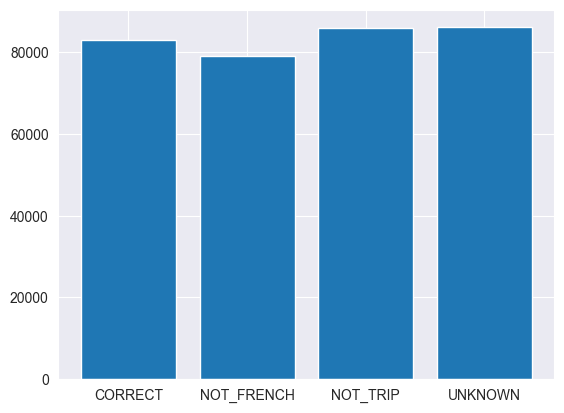

In [7]:
import matplotlib.pyplot as plt

plt.bar(labels, [sum(train_data[label]) for label in labels])
plt.show()

In [8]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def preprocess_data(examples):
    # take a batch of texts
    text = examples["text"]

    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()

    return encoding

In [9]:
import numpy as np

encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

example = encoded_dataset['train'][0]
print(example.keys())

Map:   0%|          | 0/199264 [00:00<?, ? examples/s]

Map:   0%|          | 0/24908 [00:00<?, ? examples/s]

Map:   0%|          | 0/24908 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [10]:
tokenizer.decode(example['input_ids'])

"[CLS] Pourrais - tu m'aider à planifier le trajet de Firminy vers Avesnes - Sur - Helpe? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

In [11]:
example['labels']

[1.0, 0.0, 0.0, 1.0]

In [12]:
print([id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0])

['CORRECT', 'UNKNOWN']


In [13]:
encoded_dataset.set_format("torch")

In [14]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    problem_type="multi_label_classification",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
train_batch_size = 16
eval_batch_size = 64
epochs = 5
metric_name = "f1"

In [16]:
from transformers import TrainingArguments, Trainer
args = TrainingArguments(
    f"bert-finetuned-sem_trip",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=eval_batch_size,
    num_train_epochs=epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

In [17]:
import torch
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
                                           tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [18]:
outputs = model(
    input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), 
    attention_mask=encoded_dataset['train']['attention_mask'][0].unsqueeze(0), 
    labels=encoded_dataset['train'][0]['labels'].unsqueeze(0)
)
outputs

SequenceClassifierOutput(loss=tensor(0.7874, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[-0.1903,  0.0164,  0.2549, -0.2516]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [19]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss


TrainOutput(global_step=62270, training_loss=0.006069475534889965, metrics={'train_runtime': 11254.7042, 'train_samples_per_second': 88.525, 'train_steps_per_second': 5.533, 'total_flos': 6.553687850631168e+16, 'train_loss': 0.006069475534889965, 'epoch': 5.0})

In [21]:
trainer.save_model("bert-finetuned-sem_trip")

In [22]:
trainer.evaluate()

{'eval_loss': 0.0031677004881203175,
 'eval_f1': 0.996877381183607,
 'eval_roc_auc': 0.9979623740079496,
 'eval_accuracy': 0.9916091215673679,
 'eval_runtime': 67.3065,
 'eval_samples_per_second': 370.069,
 'eval_steps_per_second': 5.794,
 'epoch': 5.0}

In [23]:
text = "Nantes vers Paris"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

In [24]:
logits = outputs.logits
logits.shape

torch.Size([1, 4])

In [25]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

['CORRECT']


In [26]:
y_true = encoded_dataset['test']['labels']
y_pred = trainer.predict(encoded_dataset['test']).predictions

# Normalize predictions to 0 and 1
sigmoid = torch.nn.Sigmoid()
y_pred = sigmoid(torch.Tensor(y_pred)).numpy()
y_pred = np.where(y_pred >= 0.5, 1.0, 0.0)

y_true = y_true.numpy()
y_pred = np.array(y_pred)

print(y_true.shape)
print(y_pred.shape)

print(y_true[:5])
print(y_pred[:5])

(24908, 4)
(24908, 4)
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


In [27]:
from sklearn.metrics import multilabel_confusion_matrix

y_true_binary = np.argmax(y_true, axis=1)
y_pred_binary = np.argmax(y_pred, axis=1)

cm = multilabel_confusion_matrix(y_true, y_pred)

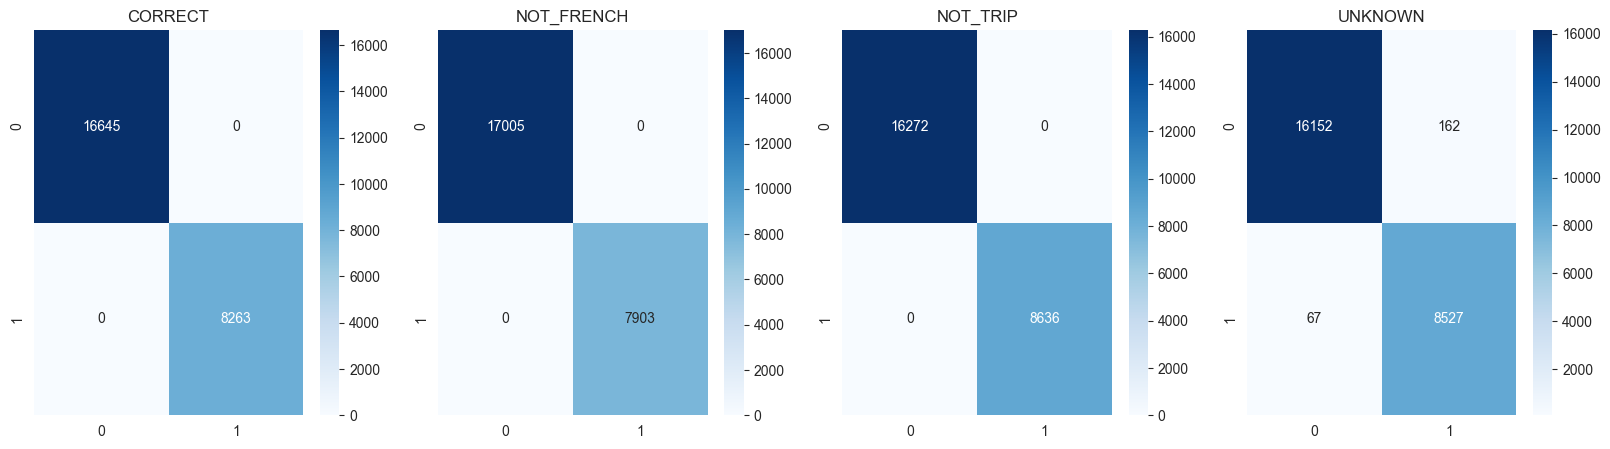

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, len(labels), figsize=(20, 5))

for i, label in enumerate(labels):
    sns.heatmap(cm[i], annot=True, fmt='d', ax=ax[i], cmap='Blues')
    ax[i].set_title(label)
    
plt.show()

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

     CORRECT       1.00      1.00      1.00      8263
  NOT_FRENCH       1.00      1.00      1.00      7903
    NOT_TRIP       1.00      1.00      1.00      8636
     UNKNOWN       0.98      0.99      0.99      8594

   micro avg       1.00      1.00      1.00     33396
   macro avg       1.00      1.00      1.00     33396
weighted avg       1.00      1.00      1.00     33396
 samples avg       1.00      1.00      1.00     33396
